In [1]:
import skrf as rf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def data_to_network(file_name, freq, mag, phase):
    s = np.zeros((len(freq), 2, 2), dtype=complex)
    fn = file_name.lower()
    if 's11' in fn or 'open' in fn or 'short' in fn or 'load' in fn or 'one' in fn:
        s[:, 0, 0] = rf.dbdeg_2_reim(mag, phase)
        network = rf.Network(f=freq, s=s[:,0,0], name=file_name, f_unit='Hz')
    elif 's21' in fn or 'thru' in fn or 'through' in fn or 'two' in fn:
        s[:, 1, 0] = rf.dbdeg_2_reim(mag, phase)
        s[:, 1, 1] = rf.dbdeg_2_reim(mag, phase)
        network = rf.Network(f=freq, s=s, name=file_name, f_unit='Hz')
    else:
        var = input("Unable to determine S param, please enter S11 or S21")
        if "s11" in var:
            s[:, 0, 0] = rf.dbdeg_2_reim(mag, phase)
            network = rf.Network(f=freq, s=s[:,0,0], name=file_name, f_unit='Hz')
        elif "s21" in var:
            s[:, 1, 0] = rf.dbdeg_2_reim(mag, phase)
            network = rf.Network(f=freq, s=s[:,0,0], name=file_name, f_unit='Hz')
        else:
            print("Still unable to figure it out, try changing file name")

    return network

def load(file_name):
    """ Loads CSV from file. """
    global network
    data = np.loadtxt("{}.csv".format(file_name), delimiter=",")
    freq = data[:, 0]
    mag = data[:, 1]
    phase = data[:, 2]
    network = data_to_network(file_name, freq, mag, phase)
    return network

In [9]:
# One Port Cal
meas_short = load("cal/cal_short")
meas_open = load("cal/cal_open")
meas_load = load("cal/cal_load")

# meas_short = rf.Network("cal/cal_short.s1p")
# meas_open = rf.Network("cal/cal_open.s1p")
# meas_load = rf.Network("cal/cal_load.s1p")

freqs = meas_load.f
frequency = meas_load.frequency

# Load cal kit files
cal_kit_short = load("data/cal_kit/cal_short_interp")
cal_kit_open = load("data/cal_kit/cal_open_interp")
cal_kit_load = load("data/cal_kit/cal_load_interp")

cal_kit_short = cal_kit_short.interpolate(frequency)
cal_kit_open = cal_kit_open.interpolate(frequency)
cal_kit_load = cal_kit_load.interpolate(frequency)

cal = rf.OnePort(\
                ideals = [cal_kit_open, cal_kit_short, cal_kit_load],
                measured = [meas_open, meas_short, meas_load],
                rcond = None
                )
cal.run()

dut = load("meass11")
dut = dut.interpolate(frequency)
dut_caled = cal.apply_cal(dut)

dut.plot_s_db(label="raw")
dut_caled.plot_s_db(label="cal")

plt.figure()
dut.plot_s_deg(label="raw")
dut_caled.plot_s_deg(label="cal")

NameError: name 'dim' is not defined

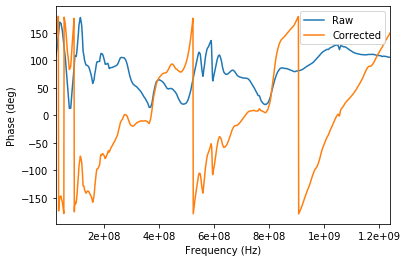

In [5]:
# Two Port Cal

# Measured with VNA
meas_short = load("cal/cal_short")
meas_open = load("cal/cal_open")
meas_load = load("cal/cal_load")
meas_thru = rf.Network("cal/cal_thru.s2p")

freqs = meas_thru.f
frequency = meas_thru.frequency

meas_short_short = rf.two_port_reflect(meas_short, meas_short)
meas_open_open = rf.two_port_reflect(meas_open, meas_open)
meas_load_load = rf.two_port_reflect(meas_load, meas_load)

# Load cal kit files
cal_kit_short = load("data/cal_kit/cal_short_interp")
cal_kit_open = load("data/cal_kit/cal_open_interp")
cal_kit_load = load("data/cal_kit/cal_load_interp")

cal_kit_short_short = rf.two_port_reflect(cal_kit_short, cal_kit_short)
cal_kit_open_open = rf.two_port_reflect(cal_kit_open, cal_kit_open)
cal_kit_load_load = rf.two_port_reflect(cal_kit_load, cal_kit_load)

cal_kit_short_short = cal_kit_short_short.interpolate(frequency)
cal_kit_open_open = cal_kit_open_open.interpolate(frequency)
cal_kit_load_load = cal_kit_load_load.interpolate(frequency)

# Generate thru standard

through_delay = 51.1e-12
d = 2*np.pi*through_delay
through_s = [[[0,np.exp(-1j*d*f)],[np.exp(-1j*d*f),0]] for f in freqs]
through_i = rf.Network(s=through_s, f=freqs, f_unit='Hz')

cal = rf.TwelveTerm(\
        measured = [meas_open_open, meas_short_short, meas_load_load, meas_thru],
        ideals =[cal_kit_open_open, cal_kit_short_short, cal_kit_load_load, through_i],
        n_thrus = 1,
        isolation=meas_load_load,
        rcond = None
        )

cal.run()

dut = load("filters21")
dut = dut.interpolate(frequency)
dut.plot_s_deg(m=1, n=0, label="Raw")
dut = cal.apply_cal(dut)
dut.plot_s_deg(m=1, n=0, label="Corrected")